In [2]:
import numpy as np
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

import statmorph
from photutils.segmentation import detect_threshold, detect_sources
from statmorph.utils.image_diagnostics import make_figure
import utils.data
import utils.plots as plots

# Galaxy Toy model test

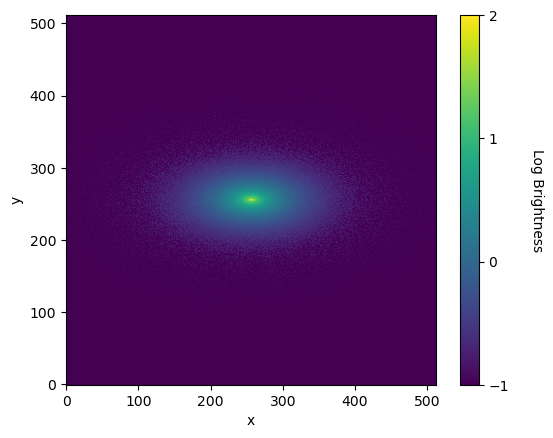

In [3]:
x, y = np.meshgrid(np.arange(512), np.arange(512))
r_eff = 50
n = 3
ellip = 0.5
mod = models.Sersic2D(amplitude=1, r_eff=r_eff, n=n, x_0=256, y_0=256,
               ellip=ellip, theta=0)
img = mod(x, y)
img += 0.1*np.random.random(size=img.shape)
log_img = np.log10(img)

fig, ax = plt.subplots()
im = ax.imshow(log_img, origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Statmorph fit

Regular circular mask...

In [4]:
center = (len(log_img[1])//2, len(log_img[0])//2)
mask = utils.data.circular_mask(image=img, image_center=center,
                                radius=256)
morph = statmorph.source_morphology(image=img, segmap=mask, gain=2.25)

n:
True = 3 | Fit = 6.752944909513628
rhalf:
 True = 50 | Fit = 58.124514939403205
ellipticity:
 True = 0.5 | Fit = 0.12805352186517815


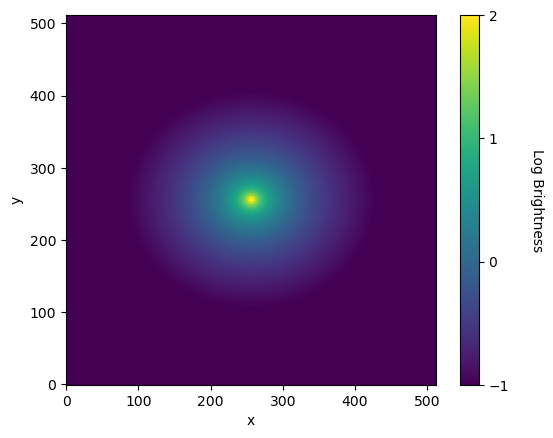

In [7]:
print(f"n:\nTrue = {n} | Fit = {morph[0].sersic_n}")
print(f"rhalf:\n True = {r_eff} | Fit = {morph[0].rhalf_ellip}")
print(f"ellipticity:\n True = {ellip} | Fit = {morph[0].ellipticity_asymmetry}")

sm_mod = models.Sersic2D(amplitude=1, r_eff=morph[0].rhalf_ellip,
                         n= morph[0].sersic_n, x_0=256, y_0=256,
                         ellip=morph[0].ellipticity_asymmetry, theta=0)
sm_img = sm_mod(x, y)
fig, ax = plt.subplots()
im = ax.imshow(np.log10(sm_img), origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Manual crop then full segmap...

In [8]:
mask = utils.data.circular_mask(img, center, radius=1024)
cropped_img = np.where(mask, img, 0)
segmap = np.ones_like(img).astype(int)
center = (len(log_img[1])//2, len(log_img[0])//2)
morph = statmorph.source_morphology(image=img, segmap=segmap, gain=2.25)

n:
True = 3 | Fit = 3.4865703599699494
rhalf:
 True = 50 | Fit = 76.79089487522928
ellipticity:
 True = 0.5 | Fit = 0.08931577823399772


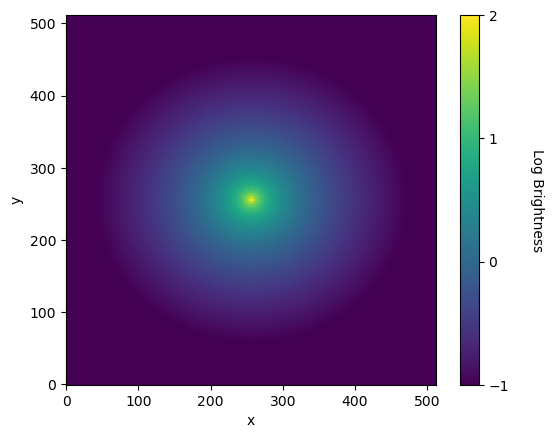

In [10]:
print(f"n:\nTrue = {n} | Fit = {morph[0].sersic_n}")
print(f"rhalf:\n True = {r_eff} | Fit = {morph[0].rhalf_ellip}")
print(f"ellipticity:\n True = {ellip} | Fit = {morph[0].ellipticity_asymmetry}")

sm_mod = models.Sersic2D(amplitude=1, r_eff=morph[0].rhalf_ellip,
                         n=morph[0].sersic_n, x_0=256, y_0=256,
                         ellip=morph[0].ellipticity_asymmetry, theta=0)
sm_img = sm_mod(x, y)
fig, ax = plt.subplots()
im = ax.imshow(np.log10(sm_img), origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

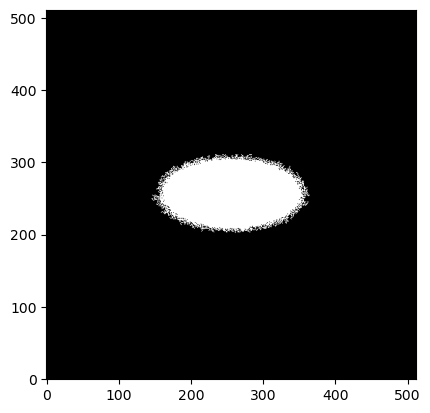

In [11]:
segmap = utils.data.segmentation_map(img, npixels=100)
plt.imshow(segmap, origin='lower', cmap='gray')

In [12]:
morph = statmorph.source_morphology(image=img, segmap=segmap, gain=2.25)

In [13]:
print(f"n:\nTrue = {n} | Fit = {morph[0].sersic_n}")
print(f"rhalf:\n True = {r_eff} | Fit = {morph[0].rhalf_ellip}")
print(f"ellipticity:\n True = {ellip} | Fit = {morph[0].ellipticity_asymmetry}")

n:
True = 3 | Fit = 6.754491787279683
rhalf:
 True = 50 | Fit = 60.390990088557665
ellipticity:
 True = 0.5 | Fit = 0.4981048883637865


### Astropy fit

In [14]:
fit_model = models.Sersic2D(
    amplitude=1.0, r_eff=30.0, n=2.0,
    x_0=256, y_0=256, ellip=0.1, theta=0.0
)

fitter = fitting.LevMarLSQFitter()          # uses old scipy method
best_fit = fitter(fit_model, x, y, img, maxiter=1000)
flags = {1: "Success",
         2: "Success",
         3: "Success",
         4: "Success",
         5: "Fail"}
print(f"Fit n: {best_fit.n.value}")
print(f"Fit r_eff: {best_fit.r_eff.value}")
print(f"Fit ellip: {best_fit.ellip.value}")
print(f"Message: {fitter.fit_info['message']}")
print(f"Fit: {flags[fitter.fit_info['ierr']]}")

Fit n: 3.2020241256763002
Fit r_eff: 34.97728632313763
Fit ellip: 0.37644245830267814
Message: The relative error between two consecutive iterates is at most 0.000000
Fit: Success


In [43]:
x, y = np.meshgrid(np.arange(100), np.arange(100))
fit_mod = models.Sersic2D(best_fit.parameters)
fit_img = fit_model(x, y)
res = img - fit_img
plt.imshow(res, origin='lower')
plt.colorbar()

ValueError: operands could not be broadcast together with shapes (2048,2048) (100,100) 

In [120]:
fit_model = models.Sersic2D(
    amplitude=1.0, r_eff=15.0, n=1.0,
    x_0=50.0, y_0=50.0, ellip=0.1, theta=0.0
)

fitter = fitting.LMLSQFitter()              # new, up-to-date scipy methods
best_fit = fitter(fit_model, x, y, img, maxiter=10000)

print(f"Fit n: {best_fit.n.value}")
print(f"Fit r_eff: {best_fit.r_eff.value}")
print(f"Fit ellip: {best_fit.ellip.value}")
print(f"Status: {fitter.fit_info['status']}")
print(f"Success: {fitter.fit_info['success']}")
print(f"Message: {fitter.fit_info['message']}")

Fit n: 7.03597616567687
Fit r_eff: 14.848361160205512
Fit ellip: 0.7064022293636665
Status: 3
Success: True
Message: `xtol` termination condition is satisfied.


/var/folders/s0/lggtcgss1ybb5pnxffm57clh0000gn/T/ipykernel_27025/3525879619.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(res), origin='lower')


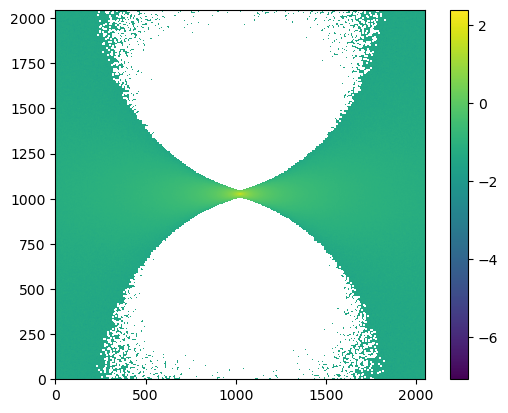

In [46]:
x, y = np.meshgrid(np.arange(2048), np.arange(2048))
fit_mod = models.Sersic2D(best_fit.parameters)
fit_img = fit_model(x, y)
res = img - fit_img
plt.imshow(np.log10(res), origin='lower')
plt.colorbar()

Model 2

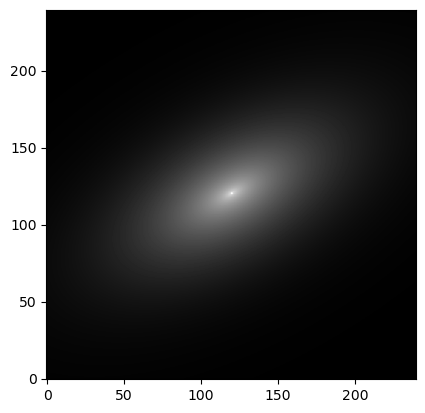

In [21]:
ny, nx = 240, 240
x, y = np.meshgrid(np.arange(240), np.arange(240))
r_eff = 20
n = 2.5
ellip = 0.5
sersic_model = models.Sersic2D(
    amplitude=1, r_eff=r_eff, n=n, x_0=120, y_0=120,
    ellip=ellip, theta=0.5)
image = sersic_model(x, y)
plt.imshow(image, cmap='gray', origin='lower',
           norm=simple_norm(image, stretch='log', log_a=10000))

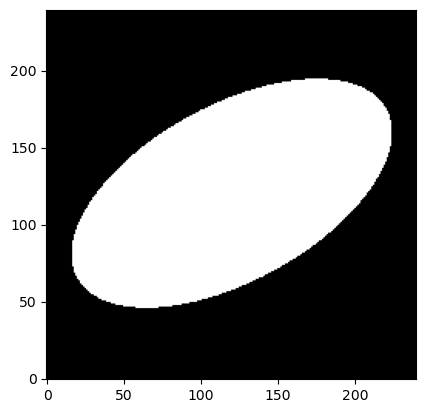

In [22]:
threshold = detect_threshold(image, 1.5)
npixels = 5  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels)
plt.imshow(segmap, origin='lower', cmap='gray')

In [23]:
source_morphs = statmorph.source_morphology(
    image, segmap, gain=2.25)

In [24]:
morph = source_morphs[0]
print("n = ", morph.sersic_n)
print("rhalf = ", morph.rhalf_ellip)
print("ellipticity = ", morph.ellipticity_asymmetry)

n =  2.4999999967463182
rhalf =  19.793397475130188
ellipticity =  0.5000408772824801


In [25]:
center = (len(image[1])//2, len(image[0])//2)
mask = utils.data.circular_mask(image=img, image_center=center,
                                radius=120)
morph = statmorph.source_morphology(image=img, segmap=mask, gain=2.25)

In [26]:
print(f"n:\nTrue = {n} | Fit = {morph[0].sersic_n}")
print(f"rhalf:\n True = {r_eff} | Fit = {morph[0].rhalf_ellip}")
print(
    f"ellipticity:\n True = {ellip} | Fit = {morph[0].ellipticity_asymmetry}")

n:
True = 2.5 | Fit = 5.733601818942887
rhalf:
 True = 20 | Fit = 270.9879787564546
ellipticity:
 True = 0.5 | Fit = 0.38796761407159686


In [29]:
mask = utils.data.circular_mask(image, center, radius=1024)
cropped_img = np.where(mask, image, 0)
segmap = np.ones_like(image).astype(int)
center = (len(image[1])//2, len(image[0])//2)
morph = statmorph.source_morphology(image=image, segmap=segmap, gain=2.25)

n:
True = 2.5 | Fit = 2.5000000001115565
rhalf:
 True = 20 | Fit = 18.880730308889728
ellipticity:
 True = 0.5 | Fit = 0.44820821065985383


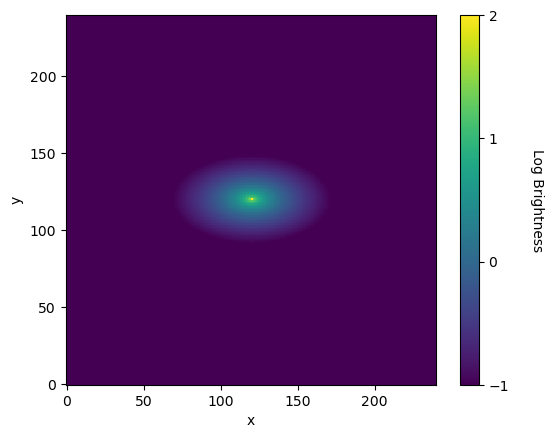

In [34]:
print(f"n:\nTrue = {n} | Fit = {morph[0].sersic_n}")
print(f"rhalf:\n True = {r_eff} | Fit = {morph[0].rhalf_ellip}")
print(
    f"ellipticity:\n True = {ellip} | Fit = {morph[0].ellipticity_asymmetry}")

sm_mod = models.Sersic2D(amplitude=1, r_eff=morph[0].rhalf_ellip,
                         n=morph[0].sersic_n, x_0=center[0], y_0=center[1],
                         ellip=morph[0].ellipticity_asymmetry, theta=0)
sm_img = sm_mod(x, y)
fig, ax = plt.subplots()
im = ax.imshow(np.log10(sm_img), origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [27]:
fit_model = models.Sersic2D(
    amplitude=1.0, r_eff=15.0, n=2.0,
    x_0=120, y_0=120, ellip=0.1, theta=0.0
)

fitter = fitting.LevMarLSQFitter()    
best_fit = fitter(fit_model, x, y, image, maxiter=500)

print(f"Fit n: {best_fit.n.value}")
print(f"Fit r_eff: {best_fit.r_eff.value}")
print(f"Fit ellip: {best_fit.ellip.value}")
print(f"Message: {fitter.fit_info['message']}")

Fit n: 2.8326374516845587
Fit r_eff: 22.871516549687726
Fit ellip: 0.5000331288773933
Message: The relative error between two consecutive iterates is at most 0.000000
